enter number of layers101


C:\Users\prath\AppData\Local\Temp\ipykernel_30756\286922167.py:56: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += get_cost_operator_circuit(G,gamma[i])
C:\Users\prath\AppData\Local\Temp\ipykernel_30756\286922167.py:57: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += get_mixer_operator_circuit(G,beta[i])
C:\Users\prath\AppData\Local\Temp\ipykernel_30756\286922167.py:161: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += get_cost_operator_circuit(

for 1 entropy is 2.0277972206142167
for 2 entropy is 2.3858157612227644
for 3 entropy is 2.6712766324491315
for 4 entropy is 2.7560672015755525
for 5 entropy is 2.79735754151429
for 6 entropy is 2.8580097467485333
for 7 entropy is 2.9054229088762065
for 8 entropy is 2.8814423016562913
for 9 entropy is 2.9271981763363764
for 10 entropy is 2.94241764878522
for 11 entropy is 2.9465494763700977
for 12 entropy is 2.943858440321999
for 13 entropy is 2.9559076708662615
for 14 entropy is 2.9581011678971034
for 15 entropy is 2.960410872030536
for 16 entropy is 2.957123672905952
for 17 entropy is 2.9627611549733888
for 18 entropy is 2.966858525045917
for 19 entropy is 2.9630581582898414
for 20 entropy is 2.965780757766065
for 21 entropy is 2.9645798417701927
for 22 entropy is 2.9668641355703254
for 23 entropy is 2.9646875589764554
for 24 entropy is 2.96594110506496
for 25 entropy is 2.966219685419746
for 26 entropy is 2.964295492726363
for 27 entropy is 2.9668406908678255
for 28 entropy is 2.971

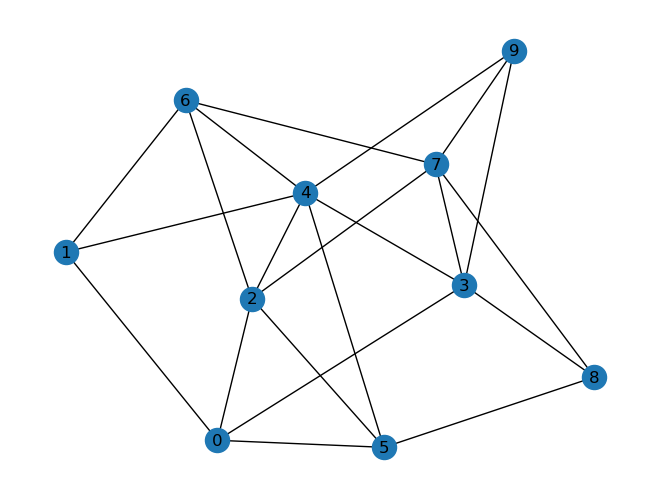

In [1]:
import qiskit
import random
import scipy.linalg
import math
import csv
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import *

m=int(input("enter number of layers"))
#initialise graph
seed = 1158
G = nx.barabasi_albert_graph(10, 3, seed=None, initial_graph=None)
nx.draw(G, with_labels=True)

#cost operator
def append_zz_term(qc, q1, q2, gamma):
    qc.cx(q1,q2)
    qc.rz(2*gamma, q2)
    qc.cx(q1,q2)

def get_cost_operator_circuit(G, gamma):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for i, j in G.edges():
        append_zz_term(qc, i, j, gamma)
    return qc
qc = get_cost_operator_circuit(G, np.pi / 3)

#mixer operator
def append_x_term(qc, q1, beta):
    qc.rx(2*beta, q1)

def get_mixer_operator_circuit(G, beta):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for n in G.nodes():
        append_x_term(qc, n, beta)
    return qc
qc = get_mixer_operator_circuit(G, np.pi/3)

#QAOA CIRCUIT
def get_qaoa_circuit(G, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta) # infering number of QAOA steps from the parameters passed
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    # first, apply a layer of Hadamards
    qc.h(range(N))
    # second, apply p alternating operators
    for i in range(p):
        qc += get_cost_operator_circuit(G,gamma[i])
        qc += get_mixer_operator_circuit(G,beta[i])
    # finally, do not forget to measure the result!
    qc.barrier(range(N))
    qc.measure(range(N), range(N))
    return qc
qc = get_qaoa_circuit(G,[np.pi/3], [np.pi/2])

#to fix qiskit qubit ordering
def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()}
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend)
result = job.result()

#defining maxcut values and stuff
def maxcut_obj(x,G):
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            # the edge is cut
            cut -= 1
    return cut

def compute_maxcut_energy(counts, G):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        obj_for_meas = maxcut_obj(meas, G)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return energy / total_counts

#the circuit put inside a blackbox
def get_black_box_objective(G,p):
    backend = Aer.get_backend('qasm_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        beta = theta[:p]
        gamma = theta[p:]
        qc = get_qaoa_circuit(G,beta, gamma)
        counts = execute(qc, backend, seed_simulator=10).result().get_counts()
        # return the energy
        return compute_maxcut_energy(invert_counts(counts), G)
    return f

entropy=[]
layers=[]
entropy_data=[]
    
for p in range(1, m):
    
    entropy_data=[]
    for c in range(1, 100):
        #the optimisation part but randomised
        obj = get_black_box_objective(G, p)
    #random.seed(69)

        my_array = []

        for i in range(p):
            my_array.append(random.uniform(0, np.pi))

        for i in range(p):
            my_array.append(random.uniform(0, 2*np.pi))

    
        init_point = my_array
        res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':0, 'disp': True})
        optimal_theta = res_sample['x']
        qc = get_qaoa_circuit(G, optimal_theta[:p], optimal_theta[p:])
        counts = invert_counts(execute(qc, backend).result().get_counts())

    # for state vector formalism
        def state_num2str(basis_state_as_num, nqubits):
            return '{0:b}'.format(basis_state_as_num).zfill(nqubits)

        def state_str2num(basis_state_as_str):
            return int(basis_state_as_str, 2)

        def state_reverse(basis_state_as_num, nqubits):
            basis_state_as_str = state_num2str(basis_state_as_num, nqubits)
            new_str = basis_state_as_str[::-1]
            return state_str2num(new_str)

        def get_adjusted_state(state):
            nqubits = np.log2(state.shape[0])
            if nqubits % 1:
                raise ValueError("Input vector is not a valid statevector for qubits.")
            nqubits = int(nqubits)

            adjusted_state = np.zeros(2**nqubits, dtype=complex)
            for basis_state in range(2**nqubits):
                adjusted_state[state_reverse(basis_state, nqubits)] = state[basis_state]
            return adjusted_state
    
        def get_qaoa_circuit_sv(G, beta, gamma):
            assert(len(beta) == len(gamma))
            p = len(beta) # infering number of QAOA steps from the parameters passed
            N = G.number_of_nodes()
            qc = QuantumCircuit(N,N)
    # first, apply a layer of Hadamards
            qc.h(range(N))
    # second, apply p alternating operators
            for i in range(p):
                qc += get_cost_operator_circuit(G,gamma[i])
                qc += get_mixer_operator_circuit(G,beta[i])
    # no measurement in the end!
            return qc

        def state_to_ampl_counts(vec, eps=1e-15):
            qubit_dims = np.log2(vec.shape[0])
            if qubit_dims % 1:
                raise ValueError("Input vector is not a valid statevector for qubits.")
            qubit_dims = int(qubit_dims)
            counts = {}
            str_format = '0{}b'.format(qubit_dims)
            for kk in range(vec.shape[0]):
                val = vec[kk]
                if val.real**2+val.imag**2 > eps:
                    counts[format(kk, str_format)] = val
            return counts
#To get the State Vector of QAOA
        backend = Aer.get_backend('statevector_simulator')
        qc = get_qaoa_circuit_sv(G, optimal_theta[:p], optimal_theta[p:])
        sv = get_adjusted_state(execute(qc, backend).result().get_statevector())
        matrix=state_to_ampl_counts(sv)
#To convert our state vector output into a proper matrix (with a given bipartition)   
        values = np.array(list(matrix.values()))
        output = np.reshape(values, (-1, 32)) # reshape the array and extract the amplitudes
        truematrix = output.T
        U, D, V = scipy.linalg.svd(truematrix) # following is to do an SVD of the matrix to get schmidt coefficients
        precision = 4
        singular = [round(num, precision) for num in D]
        total = 0
        for num in singular:
            if num != 0:
                total += (-1)*(num**2 * math.log(num**2))
        entropy_data.append(total)
    entropyavg = sum(entropy_data) / len(entropy_data)   # to average our data for more accurate data. 
    entropy.append(entropyavg)
    layers.append(p)
    print("for", p, "entropy is", entropyavg)
    
    

# to save the data into given .csv files    
file_path1 = 'entropyBG10M3.csv'
with open(file_path1, mode='w', newline='') as file:
    writer = csv.writer(file)
    for value in entropy:
        writer.writerow([value])

file_path2 = 'layersBG10M3.csv'
with open(file_path2, mode='w', newline='') as file:
    writer = csv.writer(file)
    for value in layers:
        writer.writerow([value])
